# Stock Market Price Predction Using Stacked LSTM

## Collecting Stock Data from AAPL

In [1]:
import pandas_datareader as pdr #for using the tiingo api
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

True

In [3]:
key = os.environ.get('API_KEY')

In [4]:
dataset = pdr.get_data_tiingo('AAPL',api_key=key)

In [5]:
dataset.to_csv('AAPL.csv')

In [56]:
import pandas as pd

In [57]:
dataset = pd.read_csv('AAPL.csv')

In [58]:
dataset.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2019-01-22 00:00:00+00:00,153.30,156.73,152.62,156.41,30393970,36.783597,37.606609,36.620434,37.529826,121575880,0.0,1.0
1,AAPL,2019-01-23 00:00:00+00:00,153.92,155.14,151.70,154.15,23130570,36.932363,37.225096,36.399685,36.987550,92522280,0.0,1.0
2,AAPL,2019-01-24 00:00:00+00:00,152.70,154.48,151.74,154.11,25441549,36.639630,37.066732,36.409282,36.977952,101766196,0.0,1.0
3,AAPL,2019-01-25 00:00:00+00:00,157.76,158.13,154.32,155.48,33547893,37.853752,37.942532,37.028341,37.306677,134191572,0.0,1.0
4,AAPL,2019-01-28 00:00:00+00:00,156.30,156.33,153.66,155.79,26192058,37.503432,37.510631,36.869977,37.381060,104768232,0.0,1.0


In [59]:
# taking only the close column for prediction
dataset=dataset.reset_index()['close']

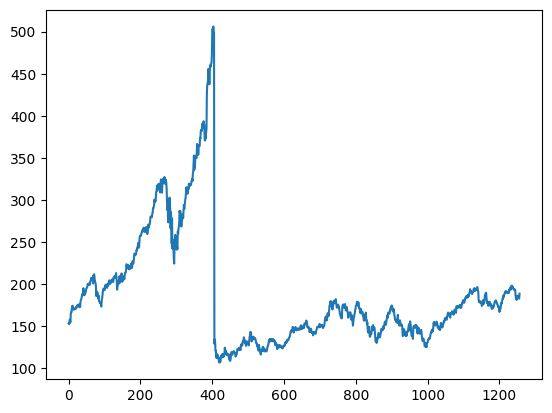

In [60]:
import matplotlib.pyplot as plt
plt.plot(dataset)

## Preprocessing the Dataset

In [61]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [62]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(np.array(dataset).reshape(-1,1))

## Splitting the Datatset

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
# note that here in time series data the split is not a 
# random split as the vales depends on the previous days as well
# so we should divide on the basis of dates
# dataset_train, dataset_test = train_test_split(dataset, test_size=0.35, random_state=42)

training_size=int(len(dataset)*0.65)
test_size=len(dataset)-training_size
train_data,test_data=dataset[0:training_size,:],dataset[training_size:len(dataset),:]

In [65]:
# converting an array of values into dataset matrix
# here timestep indicates that to calculate the current day we need to consider 
# previous timestep days, now let say its value is 3
# so every entry now has 3 days before as independant and one dependant current day

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [66]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [67]:
# reshaping input to be [samples, time steps, features] for fulfit LSTM input requirements
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Training Stacked LSTM model

In [68]:
import tensorflow as tf

In [69]:
tf.test.is_built_with_cuda() # checking for GPU

True

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
# first input shape is 2nd and the 3rd dimention i.e (100,1) -> dimentions of each element 
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [20]:
model.compile(loss='mean_squared_error',optimizer='adam')


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 18s 229ms/step - loss: 0.0334 - val_loss: 8.0125e-04
Epoch 2/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0151 - val_loss: 0.0039
Epoch 3/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0114 - val_loss: 3.6296e-04
Epoch 4/100
12/12 [==============================] - 1s 67ms/step - loss: 0.0088 - val_loss: 4.5979e-04
Epoch 5/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0087 - val_loss: 4.7805e-04
Epoch 6/100
12/12 [==============================] - 1s 71ms/step - loss: 0.0075 - val_loss: 2.8005e-04
Epoch 7/100
12/12 [==============================] - 1s 71ms/step - loss: 0.0063 - val_loss: 6.3697e-04
Epoch 8/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0055 - val_loss: 2.5751e-04
Epoch 9/100
12/12 [==============================] - 1s 70ms/step - loss: 0.0054 - val_loss: 6.2242e-04
Epoch 10/100
12/12 [==============================] - 1s 70ms/step

In [23]:
model.save("prediction_model.h5")

## Predicting test data

In [32]:
from keras.models import load_model
model = load_model("prediction_model.h5")

In [33]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 12ms/step


In [34]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [35]:
import math
from sklearn.metrics import mean_squared_error

In [36]:
# Calculate RMSE performance metrics for training
math.sqrt(mean_squared_error(y_train,train_predict))

219.1467870802802

In [37]:
# Calculate RMSE performance metrics for test
math.sqrt(mean_squared_error(y_test,test_predict))

167.75576757354054

## Plotting Output

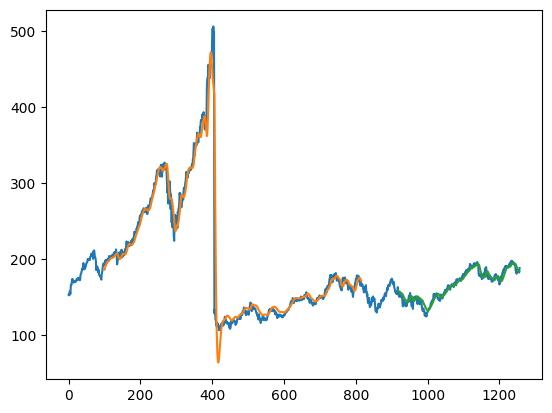

In [44]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predicting the future 30 days and Plotting output

In [71]:
len(test_data)

440

In [72]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [73]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [74]:
from numpy import array

In [76]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [77]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

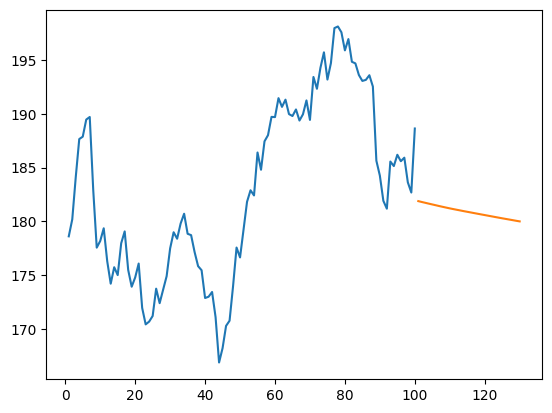

In [78]:
plt.plot(day_new,scaler.inverse_transform(dataset[len(dataset)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

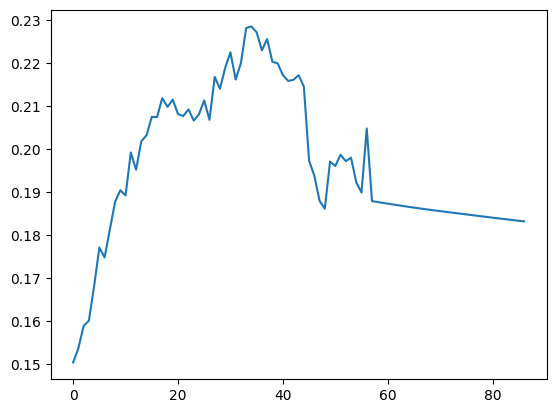

In [79]:
dataset=dataset.tolist()
dataset.extend(lst_output)
plt.plot(dataset[1200:])

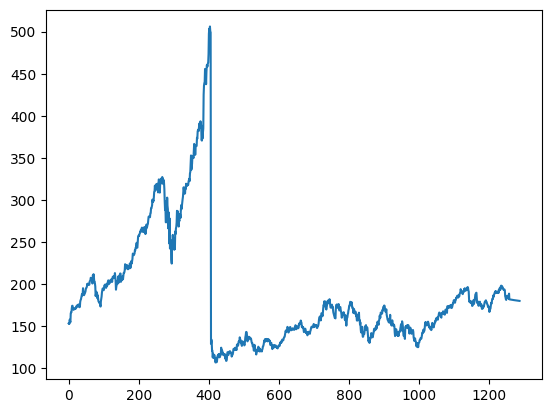

In [80]:
dataset=scaler.inverse_transform(dataset).tolist()
plt.plot(dataset)